# Metabolomics with new tables from Kelly

In [24]:
import qiime2 as q2
from qiime2.plugins.deicode.actions import rpca
import pandas as pd
from biom import Table,load_table
import os
from skbio import OrdinationResults
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from qiime2.plugins.songbird.actions import multinomial 
from qiime2.plugins.songbird.actions import summarize_paired 
from qiime2.plugins.diversity.actions import beta
import plotnine as pn
import numpy as np
from scipy.stats import sem



from scipy.stats import sem
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from math import log

import matplotlib.pyplot as plt
o="observation"
s="sample"

In [25]:
from zipfile import ZipFile
def get_q2(file):
    """Given path to modela_fit.qzv, returns q2 score"""
    with ZipFile(file, 'r') as z:
        index_file=[x for x in z.namelist() if "index.html" in x][0]
        with z.open(index_file) as f:
            q2=f.readlines()[3].split()[-1].decode("utf-8") .replace("</p>",'')
            return(q2)

## Import data

In [26]:
#Import bioms
fecal_bt = q2.Artifact.load("../data/metabolomics/new_tables/B0016_Kim_Fecal.qza").view(Table)
urine_bt = q2.Artifact.load("../data/metabolomics/new_tables/B0016_Kim_Urine.qza").view(Table)
#Import metadata
md = pd.read_csv("../data/metadata/11129_20200129-223118.txt", sep='\t', index_col=0)
fecal_md= pd.read_csv("../data/metabolomics/new_tables/B0016_Kim_Fecal_Annotations.tsv", sep='\t', index_col=0)
urine_md = pd.read_csv("../data/metabolomics/new_tables/B0016_Kim_Urine_Annotations.tsv", sep='\t', index_col=0)
fecal_md.index = [str(x) for x in fecal_md.index]
urine_md.index = [str(x) for x in urine_md.index]
#Remove blanks
blank_samples = set(x for x in md.index if "blank" in str.lower(x))
fecal_bt.filter(ids_to_keep=blank_samples & set(fecal_bt.ids()), invert=True)
urine_bt.filter(ids_to_keep=blank_samples  & set(fecal_bt.ids()), invert=True)
#Remove samples not in metadata
md_samples = set(md.index)
fecal_bt.filter(ids_to_keep=md_samples & set(fecal_bt.ids()))
urine_bt.filter(ids_to_keep=md_samples & set(urine_bt.ids()))

#Remove samples with metformin
metformin_samples = set(md.query('med_metformin_oral == "yes"').index)
fecal_bt.filter(ids_to_keep=metformin_samples & set(fecal_bt.ids()), invert=True)
urine_bt.filter(ids_to_keep=metformin_samples  & set(urine_bt.ids()), invert=True)
#Remove outliers
outlier_samples = ["11129.NT1D026.JJK.Ur"]
urine_bt.filter(ids_to_keep=outlier_samples, invert=True)

#Remove mets with 0 abundance
fecal_bt.filter(ids_to_keep= fecal_bt.ids(o)[fecal_bt.sum(o) != 0], axis=o)
urine_bt.filter(ids_to_keep= urine_bt.ids(o)[urine_bt.sum(o) != 0], axis=o)

#Rowsum normalize
f= lambda dat, _id, _md: dat/sum(dat)
fecal_bt = fecal_bt.transform(f, axis="sample")
urine_bt = urine_bt.transform(f, axis="sample")

#Convert to cpm
f= lambda dat, _id, _md: dat*1000000
fecal_bt.transform(f, axis="sample")
urine_bt.transform(f, axis="sample")

#Convert to qiime2
def b2q(bt):
    return(q2.Artifact.import_data('FeatureTable[Frequency]',bt))

data_samples = set(fecal_bt.ids()) | set(urine_bt.ids())
md = md.query('index in @data_samples')
md["host_body_mass_index_z_score"] = md.host_body_mass_index_z_score.astype("float64")
qza_md = q2.Metadata(md)

#Make biom dict
bt_dict = {"urine":urine_bt, "fecal":fecal_bt}

#Make metadata dict
md_dict = {"fecal":fecal_md.loc[:,"Compound_Name"],
           "urine":urine_md.loc[:,"Compound_Name"]}


# Beta diversity

### Calculate or import  rpca

In [29]:
rpca_dict = {"fecal":{},"urine":{}}
n_components = 4

for sample_type in ["fecal", "urine"]:
    folder = "beta_new/" + sample_type
    !mkdir -p $folder
    biplot_path = folder + "/rpca_biplot_n{}.qza".format(n_components)
    dm_path = folder + "/rpca_DM_n{}.qza".format(n_components)
    if not os.path.exists(biplot_path):
        !mkdir -p $folder
        #Calculate
        temp_biplot, temp_deicode_dm = rpca(table=b2q(bt_dict[sample_type]), n_components=n_components)
        #Add to dict
        rpca_dict[sample_type]["dm"] = temp_deicode_dm
        rpca_dict[sample_type]["biplot"] = temp_biplot
        #Save
        temp_biplot.save(biplot_path)
        temp_deicode_dm.save(dm_path)
    else:
        rpca_dict[sample_type]["biplot"] = q2.Artifact.load(biplot_path)
        rpca_dict[sample_type]["dm"] = q2.Artifact.load(dm_path)


Calculate other distance metrics

In [27]:
dm_dict = {"fecal":{},"urine":{}}
metrics=["jaccard","canberra"]

for sample_type in ["fecal", "urine"]:
    for metric in metrics:
        temp_dm = beta(table=b2q(bt_dict[sample_type]), metric=metric).distance_matrix.view(DistanceMatrix)
        dm_dict[sample_type][metric] = temp_dm
        
        

/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


### Get variables of importance to rpca overall

In [74]:
for sample_type in ["fecal","urine"]:
    #Convert format
    ordination = rpca_dict[sample_type]["biplot"].view(OrdinationResults)
    features_df = ordination.features
    #Sum absolue value of axes
    features_df["total_variation"]  = features_df.apply(axis=1, func=lambda x: sum([abs(y) for y in x[:2]]))

In [75]:
rpca_variables_dict = {}
rpca_variables_noNA_dict = {}

for sample_type in ["fecal","urine"]:
    #Convert format
    ordination = rpca_dict[sample_type]["biplot"].view(OrdinationResults)
    features_df = ordination.features
    #Sum absolue value of axes
    features_df["total_variation"]  = features_df.apply(axis=1, func=lambda x: sum([abs(y) for y in x[:2]]))
    #Add metadata
    features_df = features_df.merge(md_dict[sample_type], right_index=True, left_index=True)
    #Sort
    features_df = features_df.sort_values("total_variation", ascending=False)
    #remove nan
    features_noNA_df = features_df.loc[features_df.Compound_Name !="nan"]
    #Add to dict
    rpca_variables_dict[sample_type] = features_df
    rpca_variables_noNA_dict[sample_type] = features_noNA_df


In [76]:
def top_i(df, n=10):
    #Function for viewing a table
    return df.head(n).style.bar(subset="total_variation", align='mid', color=['#d65f5f', '#5fba7d'])

#### Fecal metabolites influencing biplot

In [77]:
top_i(rpca_variables_noNA_dict["fecal"], n=10)

,0,1,2,3,total_variation,Compound_Name
2,-0.147651,-0.0666245,-0.114566,0.078486,0.214276,Spectral Match to 12-Ketodeoxycholic acid from NIST14
1414,-0.0930564,-0.0832195,-0.0213252,0.0654934,0.176276,Spectral Match to 12-Ketodeoxycholic acid from NIST14
1441,-0.0484618,0.12566,0.000989711,0.0583168,0.174122,Spectral Match to 12-Ketodeoxycholic acid from NIST14
528,-0.111268,0.0596843,-0.00562188,0.0268069,0.170952,N-(Phenylacetyl)-L-phenylalanine
515,-0.123416,0.04375,-0.00188389,0.0184355,0.167166,Spectral Match to Abrine from NIST14
4,-0.139328,0.021308,-0.00800229,0.0477614,0.160636,trans-13-Octadecenoic acid
745,-0.143784,-0.0065819,-0.134104,0.0706814,0.150366,Stercobilin
13,-0.118433,-0.0310295,-0.0289837,0.0563694,0.149462,"(R)-4-((3R,5R,6R,8S,9S,10R,13R,14S,17R)-3,6-dihydroxy-10,13-dimethylhexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid"
535,-0.0785685,0.0398512,-4.44623e-05,0.00608297,0.11842,Spectral Match to L-Tryptophan from NIST14
465,-0.105341,-0.0109542,-0.042817,0.0759496,0.116295,Solanidine


### Urine metabolotes influencing biplot

In [78]:
top_i(rpca_variables_noNA_dict["urine"], n=10)

,0,1,2,3,total_variation,Compound_Name
2298,-0.143871,0.0131059,-0.0348752,-0.00601351,0.156977,phenylacetylglutamine
132,-0.0494962,-0.103702,-0.00553312,0.0246154,0.153198,Isovaleryl-L-carnitine
2300,-0.0335283,-0.0784364,0.0607573,0.0551705,0.111965,Isobutyryl-L-carnitine
76,-0.0871096,-0.0224822,-0.00148156,-0.000994669,0.109592,L-Tryptophan
2316,-0.071261,-0.0215175,0.0140618,-0.00186554,0.0927785,Phenylacetyl-L-glutamine
3264,0.0724437,0.0103643,0.0108896,0.0979993,0.0828079,L-Tryptophan
7771,0.0281682,0.0481555,-0.0182211,0.0332172,0.0763236,5'-METHYLTHIOADENOSINE
335,-0.0339428,-0.0400943,0.0364862,0.0259259,0.0740371,5'-METHYLTHIOADENOSINE
310,-0.0295443,-0.0437527,0.00380864,0.0385791,0.0732969,Octanoylcarnitine
7393,-0.00456874,0.0672732,-0.0247401,0.0249944,0.0718419,"N,N-Dimethylguanosine"


# Permanova

In [80]:
permanova_dict = {"fecal":{},"urine":{}}
factor_dict = {"t1d":"analysis_t1d", "weight":"analysis_weight_group", "null":"1" }

for sample_type in ["fecal", "urine"]:
    for factor in ["t1d","weight"]:
        permanova_dict[sample_type][factor] = permanova(distance_matrix=rpca_dict[sample_type]["dm"].view(DistanceMatrix),
                                                        grouping=md,
                                                        column=factor_dict[factor])
        

In [17]:
factor_dict = {"t1d":"analysis_t1d", "weight":"analysis_weight_group", "null":"1" }
perm_temp=[]

for sample_type in ["fecal", "urine"]:
    for factor in ["t1d","weight"]:
        for metric in ["jaccard","canberra"]:
            perm = permanova(distance_matrix=dm_dict[sample_type][metric],
                                                            grouping=md,
                                                            column=factor_dict[factor])
            perm_temp.append([sample_type,metric,factor,perm["sample size"], perm["test statistic"], perm["p-value"]])
permanova_summary_df= pd.DataFrame(perm_temp, columns=["sample_type","distance_metric","Variable","n","pseudo_F","p_value"])

In [59]:
permanova_summary_df.query('distance_metric=="canberra"').style.bar("pseudo_F")

,sample_type,distance_metric,Variable,n,pseudo_F,p_value
1,fecal,canberra,t1d,110,2.26595,0.008
3,fecal,canberra,weight,110,2.44897,0.002
5,urine,canberra,t1d,112,4.13448,0.001
7,urine,canberra,weight,112,2.59733,0.001


Summarize permanova results

In [81]:
temp = []
for k,v in permanova_dict.items():
    for k2,v2 in permanova_dict[k].items():
        temp.append([k,"aitchison",k2,v2["sample size"], v2["test statistic"], v2["p-value"]])
permanova_summary_df= pd.DataFrame(temp, columns=["sample_type","distance_metric","Variable","n","pseudo_F","p_value"])
permanova_summary_df.style.bar(subset=permanova_summary_df.columns[-2], align='mid', color=['#d65f5f'])

,sample_type,distance_metric,Variable,n,pseudo_F,p_value
0,fecal,aitchison,t1d,110,3.30532,0.013
1,fecal,aitchison,weight,110,2.94987,0.031
2,urine,aitchison,t1d,112,14.8972,0.001
3,urine,aitchison,weight,112,4.76524,0.002


# Differential abundance

## Calculate songbird differentials

In [1]:
!mkdir -p songbird

#Set up dictionaries
factor_dict = {"t1d":"analysis_t1d", "weight":"analysis_weight_group", "null":"1" }
songbird_dict = {"fecal":{"t1d":{},"weight":{},"null":{}},"urine":{"t1d":{},"weight":{},"null":{}}}

#Run/Import Songbird
for sample_type in songbird_dict.keys():
    for factor in ["t1d","weight","null"]:
        folder = "songbird_new/" + sample_type + "_" + factor
        if not os.path.exists(folder):
            !mkdir -p $folder
            #Calculate Songbird
            (temp_differentials,
             temp_regression_stats,
             temp_regression_biplot) = multinomial(table=b2q(bt_dict[sample_type]),
                                                   metadata=qza_md,
                                                   formula=factor_dict[factor])
            #Add outputs to master dictionary
            songbird_dict[sample_type][factor]["differentials"] = temp_differentials
            songbird_dict[sample_type][factor]["regression_stats"] = temp_regression_stats
            songbird_dict[sample_type][factor]["regression_biplot"] = temp_regression_biplot
            
            #Save outputs
            temp_differentials.save(folder + "/differentials.qza")
            temp_regression_stats.save(folder + "/regression_stats.qza")
            temp_regression_biplot.save(folder + "/regression_biplot.qza")
        else:
            songbird_dict[sample_type][factor]["differentials"] = q2.Artifact.load(folder + "/differentials.qza")
            songbird_dict[sample_type][factor]["regression_stats"] = q2.Artifact.load(folder + "/regression_stats.qza")
            songbird_dict[sample_type][factor]["regression_biplot"] = q2.Artifact.load(folder + "/regression_biplot.qza")

100%|██████████| 21000/21000 [00:51<00:00, 406.88it/s]


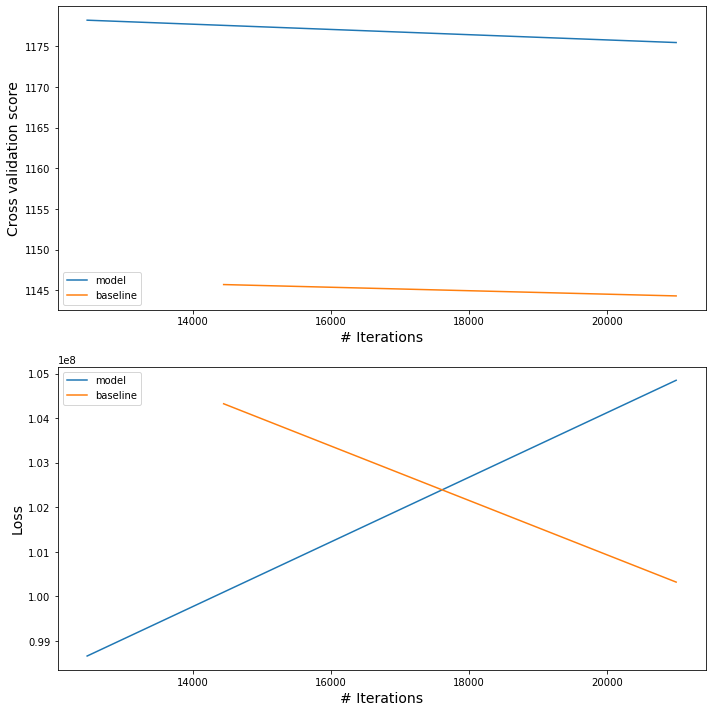

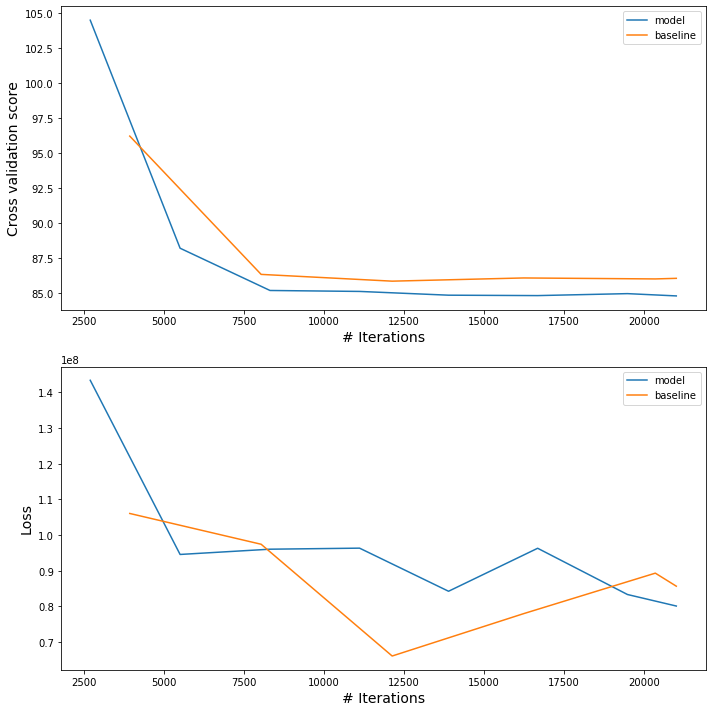

In [45]:
#Set up dictionaries
songbird_dict = {"fecal":{},"urine":{}}

formula = "analysis_t1d + host_body_mass_index_z_score"

#Run/Import Songbird
for sample_type in songbird_dict.keys():
    folder = "songbird2/" + sample_type
    !mkdir -p $folder
    #Calculate Songbird
    (temp_differentials,
     temp_regression_stats,
     temp_regression_biplot) = multinomial(table=b2q(bt_dict[sample_type]),
                                           metadata=qza_md,
                                           formula=formula,
                                          min_sample_count=0,
                                          min_feature_count=0)
    (null_differentials,
     null_regression_stats,
     null_regression_biplot) = multinomial(table=b2q(bt_dict[sample_type]),
                                           metadata=qza_md,
                                           formula="1",
                                          min_sample_count=0,
                                          min_feature_count=0)
    
    #Evaluate model fit
    tmp_model_fit = summarize_paired(regression_stats = temp_regression_stats,
                            baseline_stats = null_regression_stats).visualization

    #Add outputs to master dictionary
    songbird_dict[sample_type]["differentials"] = temp_differentials
    songbird_dict[sample_type]["regression_stats"] = temp_regression_stats
    songbird_dict[sample_type]["regression_biplot"] = temp_regression_biplot
    songbird_dict[sample_type]["model_fit"] = tmp_model_fit

    #Save outputs
    temp_differentials.save(folder + "/{}_differentials.qza".format(sample_type))
    temp_regression_stats.save(folder + "/{}_regression_stats.qza".format(sample_type))
    temp_regression_biplot.save(folder + "/{}_regression_biplot.qza".format(sample_type))
    tmp_model_fit.save(folder + "/{}_model_fit.qzv".format(sample_type))

    #Save q2 value
    q2_value = get_q2(folder + "/{}_model_fit.qzv".format(sample_type))
    songbird_dict[sample_type]["q2_value"] = q2_value
    #else:
    #    songbird_dict[sample_type]["differentials"] = q2.Artifact.load(folder + "/differentials.qza")
    #    songbird_dict[sample_type]["regression_stats"] = q2.Artifact.load(folder + "/regression_stats.qza")
    #    songbird_dict[sample_type]["regression_biplot"] = q2.Artifact.load(folder + "/regression_biplot.qza")

In [46]:
print("Feacl q2: {}".format(songbird_dict["fecal"]["q2_value"]))
print("Urine q2: {}".format(songbird_dict["urine"]["q2_value"]))

Feacl q2: -0.061160
Urine q2: 0.017551


## Get variables that separate groups

In [50]:
!ls songbird2/fecal

differentials.qza	 fecal_regression_biplot.qza  regression_biplot.qza
fecal_differentials.qza  fecal_regression_stats.qza   regression_stats.qza
fecal_model_fit.qzv	 model_fit.qzv


In [84]:
sample_type=="urine"
folder="songbird2/urine"
songbird_dict={"urine":{}}

songbird_dict[sample_type]["differentials"] = q2.Artifact.load(folder + "/differentials.qza")
songbird_dict[sample_type]["regression_stats"] = q2.Artifact.load(folder + "/regression_stats.qza")
songbird_dict[sample_type]["regression_biplot"] = q2.Artifact.load(folder + "/regression_biplot.qza")

In [85]:
sample_type= "urine"
factors=["analysis_t1d[T.T1D]","host_body_mass_index_z_score"]


differentials_df = q2.Artifact.load("songbird2/fecal/fecal_differentials.qza").view(pd.DataFrame)
#Add metabolite metadata
differentials_df = differentials_df.merge(md_dict[sample_type], right_index=True, left_index=True)
sort_col = factors[0]
t1d_differentials_df = differentials_df.loc[:,[sort_col,"Compound_Name"]].sort_values(sort_col)
sort_col = factors[1]
bmi_differentials_df = differentials_df.loc[:,[sort_col,"Compound_Name"]].sort_values(sort_col)
#differentials_df_nona = differentials_df.loc[differentials_df.Compound_Name != "nan"]
#differential_dict[sample_type][factor] = differentials_df
#differential_dict_noNA[sample_type][factor] = differentials_df_nona

In [86]:
def top_bottom(df, n=10):
    #Function for viewing a table
    return df.head(n).append(df.tail(n)).iloc[:,[1,0]].style.bar(subset=df.columns[0], align='mid', color=['#F8766D','#00BFC4'])


In [89]:
top_bottom(bmi_differentials_df, 5)

,Compound_Name,host_body_mass_index_z_score
1136,Costunolide,-0.966653
1432,Asp Leu Leu,-0.610347
889,3-Methylglutarylcarnitine,-0.479947
56,Massbank:BML01185 L-Tryptophan,-0.465392
1369,trans-Traumatic acid,-0.42573
553,Spectral Match to PyroGlu-Pro from NIST14,0.579999
772,5.alpha.-Androstan-3.beta.-ol,0.60986
1104,Decanoyl-L-carnitine,0.686546
1088,Spectral Match to L-Kynurenine from NIST14,0.707759
498,sphingosin C16 (Artifact)-emf,0.727395


In [98]:
top_bottom(t1d_differentials_df, 20)



,Compound_Name,analysis_t1d[T.T1D]
772,5.alpha.-Androstan-3.beta.-ol,-2.20849
1414,(-)-Globulol,-1.15523
1005,Asp Gly Val,-0.908724
498,sphingosin C16 (Artifact)-emf,-0.599314
1432,Asp Leu Leu,-0.597698
76,L-Tryptophan,-0.51081
23,L-PHENYLALANINE,-0.474562
846,ANSERINE,-0.440464
102,Spectral Match to Sulfadimethoxine from NIST14,-0.382193
1224,DL-Indole-3-lactic acid,-0.325099


In [126]:
fecal_met_conversion = {x.Compound_Name:x.name for name,x in fecal_md.iterrows()}
urine_met_conversion = {x.Compound_Name:x.name for name,x in urine_md.iterrows()}

In [132]:
[x for x in urine_md.Compound_Name if "dicarboxylic" in x]

['3-Oxo-1,8-octanedicarboxylic acid',
 '3-Oxo-1,8-octanedicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid']

In [130]:
metabolite="trans-2-Butene-1,4-dicarboxylic Acid = 3-hexenedioic acid diethyl ester"
met_id = urine_met_conversion[metabolite]
md_columns = ["analysis_disease_stage_group","analysis_t1d","analysis_weight_group"]
df_columns = [metabolite,"analysis_disease_stage_group","analysis_t1d","analysis_weight_group"]
sample_type="urine"

temp_df = bt_dict[sample_type]\
    .to_dataframe()\
    .transpose()\
    .loc[:,[met_id]]\
    .join(md.loc[:,md_columns])
temp_df = pd.DataFrame(temp_df)
temp_df.columns = df_columns
temp_df[metabolite] = [float(x)+1 for x in temp_df[metabolite]]

p = (pn.ggplot(data= temp_df) +
    pn.geom_boxplot( pn.aes( x="analysis_disease_stage_group", y=metabolite, group="analysis_disease_stage_group")) +
     pn.scale_y_log10() +
     pn.labs(x='', y="Intensity", title=metabolite)
    )
p

KeyError: 'trans-2-Butene-1,4-dicarboxylic Acid = 3-hexenedioic acid diethyl ester'

In [19]:
differential_dict = {"fecal":{}, "urine":{}}
differential_dict_noNA = {"fecal":{}, "urine":{}}

for sample_type in ["fecal", "urine"]:
    for factor in ["t1d","weight"]:
        differentials_df = songbird_dict[sample_type][factor]["differentials"].view(pd.DataFrame)
        #Add metabolite metadata
        differentials_df = differentials_df.merge(md_dict[sample_type], right_index=True, left_index=True)
        sort_col = differentials_df.columns[1]
        differentials_df = differentials_df.sort_values(sort_col)
        differentials_df_nona = differentials_df.loc[differentials_df.Compound_Name != "nan"]
        differential_dict[sample_type][factor] = differentials_df
        differential_dict_noNA[sample_type][factor] = differentials_df_nona

KeyError: 't1d'

In [6]:
#Save differential dicts
for sample_type in differential_dict.keys():
    for factor,df in differential_dict[sample_type].items():
        folder = "songbird_new/" + sample_type + "_" + factor
        df.to_csv(folder + "/{}_{}_songbird_differentials.tsv".format(sample_type, factor), sep='\t')

In [22]:
def top_bottom(df, n=10):
    #Function for viewing a table
    return df.head(n).append(df.tail(n)).iloc[:,[2,1]].style.bar(subset=df.columns[1], align='mid', color=['#F8766D','#00BFC4'])

### fecal T1d

In [173]:
top_bottom(differential_dict_noNA["fecal"]["t1d"], n=5)

,Compound_Name,analysis_t1d[T.T1D]
534,Spectral Match to Deoxycholic acid from NIST14,-2.72348
772,D-erythro-C18-Sphingosine,-2.29588
770,sphinganine related molecules,-2.04508
884,S-Allyl-L-Cysteine,-2.0416
771,C18_Sphingosine,-1.82414
940,Phenylacetyl-L-glutamine,0.749016
1365,"(4R)-4-((3S,5R,9S,10S,13R,14S,17R)-3-hydroxy-10,13-dimethyl-12-oxohexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid",0.798036
1508,Spectral Match to Urobilin from NIST14,0.818029
851,"(4R)-4-((3S,5S,7S,9S,10S,13R,14S,17R)-3,7-dihydroxy-10,13-dimethyl-12-oxohexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid",0.989805
1467,Spectral Match to 1-Palmitoyl-2-hydroxy-sn-glycero-3-phosphoethanolamine from NIST14,1.32906


### fecal weight

In [139]:
top_bottom(differential_dict_noNA["fecal"]["weight"], n=5)

,Compound_Name,analysis_weight_group[T.O]
1416,C18_Sphingosine,-1.51301
884,S-Allyl-L-Cysteine,-1.38725
1418,Spectral Match to D-erythro-C18-Sphingosine from NIST14,-1.01153
1508,Spectral Match to Urobilin from NIST14,-0.952838
687,8-Hydroxyquinoline-2-carbaldehyde,-0.790791
1218,"(R)-4-((3S,5S,7S,8R,9S,10S,12S,13R,14S,17R)-3,7,12-trihydroxy-10,13-dimethylhexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid",1.36835
514,"(R)-4-((3S,5S,8R,9S,10S,12S,13R,14S,17R)-3,12-dihydroxy-10,13-dimethylhexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid",1.42781
1196,"(R)-4-((3S,5S,8R,9S,10S,12S,13R,14S,17R)-3,12-dihydroxy-10,13-dimethylhexadecahydro-1H-cyclopenta[a]phenanthren-17-yl)pentanoic acid",1.52456
464,Spectral Match to Urobilin from NIST14,1.54425
1197,Cholic acid,1.6505


### urine T1d

In [93]:
def top_bottom(df, n=10):
    #Function for viewing a table
    return df.head(n).append(df.tail(n)).iloc[:,[2,1]].style.bar(subset=df.columns[1], align='mid', color=['#00BFC4','#F8766D'])

In [102]:
glucose_ids = set(urine_md.loc[["glucose" in str.lower(x) for x in urine_md.Compound_Name]].index)
urine_glucose_bt = urine_bt.filter(glucose_ids, axis=o, inplace=False)
glucose_sums = urine_glucose_bt.sum(s)
glucose_ids = urine_glucose_bt.ids()
df = pd.DataFrame(glucose_sums, glucose_ids)
df = df.merge(md.loc[:,["analysis_t1d","analysis_disease_stage_group"]], right_index=True, left_index=True)
df.columns = ["value","t1d","analysis_disease_stage_group"]

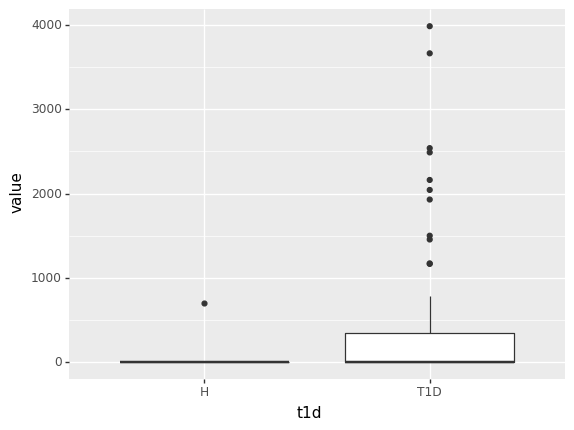

<ggplot: (-9223363268821401333)>

In [129]:
import plotnine as pn
p = (pn.ggplot(data=df) +
    pn.geom_boxplot( pn.aes(x="t1d", y="value"))
    )
p

F_onewayResult(statistic=4.35926530134238, pvalue=0.006128430204550376)


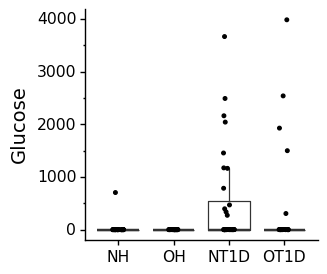

<ggplot: (8741962733551)>

In [105]:
make_boxplot(df, "analysis_disease_stage_group","value", "Glucose")

### urine weight

In [144]:
top_bottom(differential_dict_noNA["urine"]["weight"], n=5)

,Compound_Name,analysis_weight_group[T.O]
5030,Lauric acid diethanolamide,-2.28979
5458,MoNA:2736375 Ddze,-2.05593
1683,NCGC00381248-01!4-oxododecanedioic acid,-1.93532
6708,"1,2,3,4-tetrahydroharmane-3-carboxylic acid",-1.87289
4236,Spectral Match to Jasmine lactone from NIST14,-1.73122
7117,"5-Hexenoic acid, 6-[(2R,3S)-3-[[[(4-chloro-2-methylphenyl)sulfonyl]amino]methyl]bicyclo[2.2.2]oct-2-yl]-, (5Z)-",1.57487
9844,Dodecanedioic acid,1.62531
9131,Spectral Match to L-Kynurenine from NIST14,1.70312
5845,Spectral Match to L-Kynurenine from NIST14,2.24859
8300,Octanoylcarnitine,2.27396


# Biplots

In [28]:
[x for x in urine_md.Compound_Name if "Butene" in x]

['trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid',
 'trans-2-Butene-1,4-dicarboxylic acid']

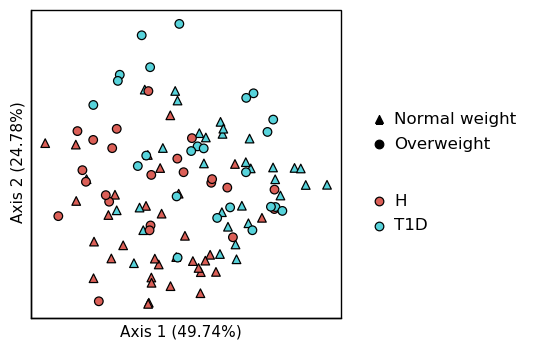

<ggplot: (8780032582811)>

In [35]:
sample_type = "urine"

pn.options.figure_size= (4,4)
arow_scale = 1.3
y_label_offset=.015
x_label_offset=.003
number_features = 8

shorten_name_dict = {'Spectral Match to .beta.-D-Glucose from NIST14':"Glucose",
                    'Spectral Match to Limonene-1,2-epoxide from METLIN':"Limonene-1,2-epoxide",
                    'Spectral Match to (R)-(+)-Citronellic acid from NIST14':"Citronellic acid",
                    'MassbankEU:SM867803 Metformin':"Metformin",
                    'MassbankEU:SM858203 Cetirizine|2-[2-[4-[(4-chlorophenyl)-phenylmethyl]piperazin-1-yl]ethoxy]acetic acid':"Cetirizine",
                    'Spectral Match to Benadryl from NIST14':"Benadryl",
                    '3-methoxymorphinan':'3-methoxymorphinan',
                    'Diphenhydramine-N-glucuronide':'Diphenhydramine-N-glucuronide',
                    'Spectral Match to Homoeriodictyol from NIST14':'Homoeriodictyol',
                    'MoNA:2736375 Ddze':'Daidzeol'}


#Format plot data
plot_dat = rpca_dict[sample_type]["biplot"].view(OrdinationResults).samples.copy()
plot_dat.columns=["axis1","axis2","axis3", "axis4"]
plot_dat = plot_dat.merge(md.query('analysis_t1d in ["H","T1D"]'), right_index=True, left_index=True)
#Get vectors from rpca
#feature_df = rpca_variables_noNA_dict[sample_type]
#feature_df = feature_df.query('Compound_Name != "1"')
#feature_df.columns=["axis1","axis2","axis3", "axis4","total_variation","Compound_Name"]
#feature_df = feature_df.iloc[:number_features,:]
#feature_df["short_name"] = [shorten_name_dict[x] for x in feature_df.Compound_Name]
#Add offset to text
#feature_df["axis1"] = [x * arow_scale for x in feature_df["axis1"]]
#feature_df["axis2"] = [x * arow_scale for x in feature_df["axis2"]]
#feature_df["text_axis1"] = [x + x_label_offset if x > 0 else x - x_label_offset for x in feature_df["axis1"]]
#feature_df["text_axis2"] = [x + y_label_offset if x > 0 else x - y_label_offset for x in feature_df["axis2"]]
#Get variance
variance = rpca_dict[sample_type]["biplot"].view(OrdinationResults).proportion_explained

p = (pn.ggplot(data = plot_dat) +
    pn.geom_point( pn.aes(x ="axis1", y="axis2", fill= "analysis_t1d", shape="analysis_weight_group"),stroke=.5, size=3) +
    #pn.geom_segment( data=feature_df, mapping=pn.aes(x=0, y=0, xend ="axis1", yend="axis2"), arrow=pn.geoms.arrow(length=.06, type="closed"), size=1) +
    #pn.geom_text( data=feature_df, mapping=pn.aes(x="text_axis1", y="text_axis2", label="Compound_Name"), size=8) +
     pn.scale_shape_manual(name=" ",values=["^","o"], labels=["Normal weight","Overweight"]) +
     #pn.scale_fill_manual(name=" ", labels=["Healthy","Type 1 Diabetes"], values=) +
    # pn.scale_x_continuous(limits=[-.05,.05]) +
     # pn.scale_y_continuous(limits=[-.25,.25]) +
     pn.guides(color=None) +
    pn.labs(x="Axis 1 ({}%)".format(round(variance[0]*100,2)),
            y="Axis 2 ({}%)".format(round(variance[1]*100,2)),
           shape='',
           fill="") +
     pn.theme_classic() +
     pn.theme(
         axis_text = pn.element_blank(),
         panel_background = pn.element_rect(size=1, color="black", fill=None),
         axis_ticks = pn.element_blank(),
         legend_text = pn.element_text(size=12)
     )
    )

p


In [31]:
from skbio.stats.ordination import pcoa

In [36]:
urine_pcoa.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112
11129.NH001.JJK.Ur,-469.027542,-1263.242342,-260.757435,-612.209988,-954.078385,-465.747547,331.676679,-369.778806,-19.378186,-189.259404,...,-51.847661,16.450704,-0.218959,32.859377,5.150134,-41.594118,-18.058529,23.646820,-9.681919,0.0
11129.NH002.JJK.Ur,5.501310,-223.552153,-445.024515,-7.360417,-64.163856,104.530492,506.121034,215.877674,56.687023,-392.762764,...,117.020633,19.587872,-12.644345,10.317352,29.882067,-19.027348,4.646125,-32.283809,3.995238,0.0
11129.NH003.JJK.Ur,-579.293880,-426.699904,-887.299208,-252.815440,-39.386024,398.959853,543.892518,-113.976992,460.740362,-787.992779,...,-9.968984,-11.080570,0.751460,-10.914140,-8.903184,1.411413,-18.578576,-17.294500,-4.118645,0.0
11129.NH004.JJK.Ur,-242.962710,436.940714,-464.238665,-609.188098,76.837826,282.910548,759.267370,214.644923,-106.282016,-39.371285,...,-127.083778,14.517668,101.930442,-13.371967,-97.964956,28.958936,24.946615,26.768538,40.446111,0.0
11129.NH005.JJK.Ur,-265.061955,283.829392,-466.609122,-752.695064,205.759985,169.022445,535.566027,36.072778,-66.341088,-217.792942,...,-54.592039,-12.939751,-10.860915,60.144706,6.475593,25.749028,-76.695853,-42.766796,11.074425,0.0


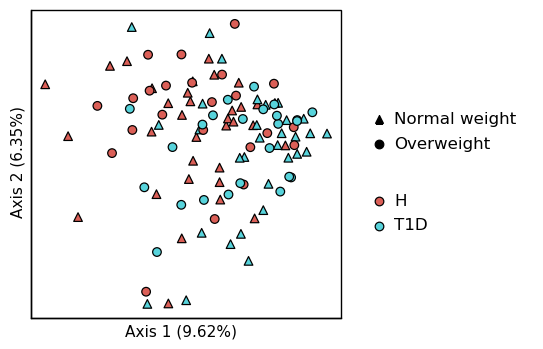

<ggplot: (-9223363264971847950)>

In [37]:
sample_type = "urine"

pn.options.figure_size= (4,4)
arow_scale = 1.3
y_label_offset=.015
x_label_offset=.003
number_features = 8

shorten_name_dict = {'Spectral Match to .beta.-D-Glucose from NIST14':"Glucose",
                    'Spectral Match to Limonene-1,2-epoxide from METLIN':"Limonene-1,2-epoxide",
                    'Spectral Match to (R)-(+)-Citronellic acid from NIST14':"Citronellic acid",
                    'MassbankEU:SM867803 Metformin':"Metformin",
                    'MassbankEU:SM858203 Cetirizine|2-[2-[4-[(4-chlorophenyl)-phenylmethyl]piperazin-1-yl]ethoxy]acetic acid':"Cetirizine",
                    'Spectral Match to Benadryl from NIST14':"Benadryl",
                    '3-methoxymorphinan':'3-methoxymorphinan',
                    'Diphenhydramine-N-glucuronide':'Diphenhydramine-N-glucuronide',
                    'Spectral Match to Homoeriodictyol from NIST14':'Homoeriodictyol',
                    'MoNA:2736375 Ddze':'Daidzeol'}


#Format plot data
urine_pcoa = pcoa(dm_dict["urine"]["canberra"])
plot_dat = urine_pcoa.samples.copy()
plot_dat = plot_dat.join(md.query('analysis_t1d in ["H","T1D"]'))
#Get vectors from rpca
#feature_df = rpca_variables_noNA_dict[sample_type]
#feature_df = feature_df.query('Compound_Name != "1"')
#feature_df.columns=["axis1","axis2","axis3", "axis4","total_variation","Compound_Name"]
#feature_df = feature_df.iloc[:number_features,:]
#feature_df["short_name"] = [shorten_name_dict[x] for x in feature_df.Compound_Name]
#Add offset to text
#feature_df["axis1"] = [x * arow_scale for x in feature_df["axis1"]]
#feature_df["axis2"] = [x * arow_scale for x in feature_df["axis2"]]
#feature_df["text_axis1"] = [x + x_label_offset if x > 0 else x - x_label_offset for x in feature_df["axis1"]]
#feature_df["text_axis2"] = [x + y_label_offset if x > 0 else x - y_label_offset for x in feature_df["axis2"]]
#Get variance
variance = urine_pcoa.proportion_explained

p = (pn.ggplot(data = plot_dat) +
    pn.geom_point( pn.aes(x ="PC1", y="PC2", fill= "analysis_t1d", shape="analysis_weight_group"),stroke=.5, size=3) +
    #pn.geom_segment( data=feature_df, mapping=pn.aes(x=0, y=0, xend ="axis1", yend="axis2"), arrow=pn.geoms.arrow(length=.06, type="closed"), size=1) +
    #pn.geom_text( data=feature_df, mapping=pn.aes(x="text_axis1", y="text_axis2", label="Compound_Name"), size=8) +
     pn.scale_shape_manual(name=" ",values=["^","o"], labels=["Normal weight","Overweight"]) +
     #pn.scale_fill_manual(name=" ", labels=["Healthy","Type 1 Diabetes"], values=) +
    # pn.scale_x_continuous(limits=[-.05,.05]) +
     # pn.scale_y_continuous(limits=[-.25,.25]) +
     pn.guides(color=None) +
    pn.labs(x="Axis 1 ({}%)".format(round(variance[0]*100,2)),
            y="Axis 2 ({}%)".format(round(variance[1]*100,2)),
           shape='',
           fill="") +
     pn.theme_classic() +
     pn.theme(
         axis_text = pn.element_blank(),
         panel_background = pn.element_rect(size=1, color="black", fill=None),
         axis_ticks = pn.element_blank(),
         legend_text = pn.element_text(size=12)
     )
    )

p


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -41717.107156595215 and the largest is 1138118.7739027601.
  RuntimeWarning


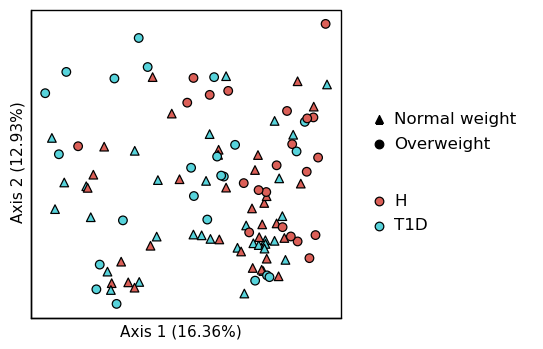

<ggplot: (-9223363264971871414)>

In [38]:
sample_type = "fecal"

pn.options.figure_size= (4,4)
arow_scale = 1.3
y_label_offset=.015
x_label_offset=.003
number_features = 8

shorten_name_dict = {'Spectral Match to .beta.-D-Glucose from NIST14':"Glucose",
                    'Spectral Match to Limonene-1,2-epoxide from METLIN':"Limonene-1,2-epoxide",
                    'Spectral Match to (R)-(+)-Citronellic acid from NIST14':"Citronellic acid",
                    'MassbankEU:SM867803 Metformin':"Metformin",
                    'MassbankEU:SM858203 Cetirizine|2-[2-[4-[(4-chlorophenyl)-phenylmethyl]piperazin-1-yl]ethoxy]acetic acid':"Cetirizine",
                    'Spectral Match to Benadryl from NIST14':"Benadryl",
                    '3-methoxymorphinan':'3-methoxymorphinan',
                    'Diphenhydramine-N-glucuronide':'Diphenhydramine-N-glucuronide',
                    'Spectral Match to Homoeriodictyol from NIST14':'Homoeriodictyol',
                    'MoNA:2736375 Ddze':'Daidzeol'}


#Format plot data
fecal_pcoa = pcoa(dm_dict["fecal"]["canberra"])
plot_dat = fecal_pcoa.samples.copy()
plot_dat = plot_dat.join(md.query('analysis_t1d in ["H","T1D"]'))
#Get vectors from rpca
#feature_df = rpca_variables_noNA_dict[sample_type]
#feature_df = feature_df.query('Compound_Name != "1"')
#feature_df.columns=["axis1","axis2","axis3", "axis4","total_variation","Compound_Name"]
#feature_df = feature_df.iloc[:number_features,:]
#feature_df["short_name"] = [shorten_name_dict[x] for x in feature_df.Compound_Name]
#Add offset to text
#feature_df["axis1"] = [x * arow_scale for x in feature_df["axis1"]]
#feature_df["axis2"] = [x * arow_scale for x in feature_df["axis2"]]
#feature_df["text_axis1"] = [x + x_label_offset if x > 0 else x - x_label_offset for x in feature_df["axis1"]]
#feature_df["text_axis2"] = [x + y_label_offset if x > 0 else x - y_label_offset for x in feature_df["axis2"]]
#Get variance
variance = fecal_pcoa.proportion_explained

p = (pn.ggplot(data = plot_dat) +
    pn.geom_point( pn.aes(x ="PC1", y="PC2", fill= "analysis_t1d", shape="analysis_weight_group"),stroke=.5, size=3) +
    #pn.geom_segment( data=feature_df, mapping=pn.aes(x=0, y=0, xend ="axis1", yend="axis2"), arrow=pn.geoms.arrow(length=.06, type="closed"), size=1) +
    #pn.geom_text( data=feature_df, mapping=pn.aes(x="text_axis1", y="text_axis2", label="Compound_Name"), size=8) +
     pn.scale_shape_manual(name=" ",values=["^","o"], labels=["Normal weight","Overweight"]) +
     #pn.scale_fill_manual(name=" ", labels=["Healthy","Type 1 Diabetes"], values=) +
    # pn.scale_x_continuous(limits=[-.05,.05]) +
     # pn.scale_y_continuous(limits=[-.25,.25]) +
     pn.guides(color=None) +
    pn.labs(x="Axis 1 ({}%)".format(round(variance[0]*100,2)),
            y="Axis 2 ({}%)".format(round(variance[1]*100,2)),
           shape='',
           fill="") +
     pn.theme_classic() +
     pn.theme(
         axis_text = pn.element_blank(),
         panel_background = pn.element_rect(size=1, color="black", fill=None),
         axis_ticks = pn.element_blank(),
         legend_text = pn.element_text(size=12)
     )
    )

p


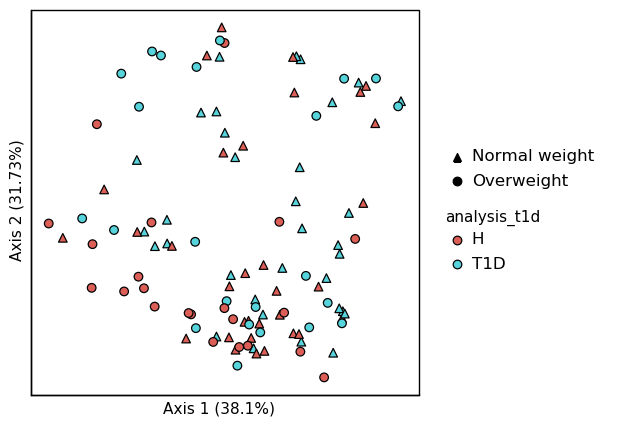

<ggplot: (-9223363256822246207)>

In [36]:
pn.options.figure_size = (5,5)

shorten_name_dict = {'Spectral Match to 12-Ketodeoxycholic acid from NIST14':'12-Ketodeoxycholic acid',
 'Spectral Match to Conjugated linoleic Acid (10E,12Z) from NIST14':'Conjugated linoleic Acid',
 'Spectral Match to Conjugated linoleic Acid (10E,12Z) from NIST14':'Conjugated linoleic Acid',
 'Spectral Match to 12-Ketodeoxycholic acid from NIST14':'12-Ketodeoxycholic acid',
 'Spectral Match to Chenodeoxycholic acid from NIST14': 'Chenodeoxycholic acid',
 'Spectral Match to Sulfadimethoxine from NIST14':'Sulfadimethoxine',
 'Spectral Match to 12-Ketodeoxycholic acid from NIST14':'12-Ketodeoxycholic acid',
 'NCGC00180141-02!2-[[7-hydroxy-1-(4-hydroxy-3,5-dimethoxyphenyl)-3-(hydroxymethyl)-6,8-dimethoxy-1,2,3,4-tetrahydronaphthalen-2-yl]methoxy]-6-(hydroxymethyl)oxane-3,4,5-triol':'NCGC00180141-02',
 'Spectral Match to Cholic acid from NIST14':'Cholic acid' ,
 'Spectral Match to Sulfadimethoxine from NIST14':'Sulfadimethoxine',
 'Spectral Match to Cetirizine from NIST14':'Cetirizine',
 'Spectral Match to Capsaicin from NIST14':'Capsaicin',
 'Spectral Match to D-Turanose from NIST14':'D-Turanose'}

sample_type = "fecal"

arow_scale = .2
y_label_offset=.02
x_label_offset=.003
n_mets = 5

#Format plot data
plot_dat = rpca_dict[sample_type]["biplot"].view(OrdinationResults).samples.copy()
plot_dat.columns=["axis1","axis2","axis3", "axis4"]
plot_dat = plot_dat.merge(md.query('analysis_t1d in ["H","T1D"]'), right_index=True, left_index=True)

#Get vectors from rpca
#feature_df = rpca_variables_noNA_dict["fecal"]
#feature_df = feature_df.query('Compound_Name != "1"')
#feature_df.columns=["axis1","axis2","axis3", "axis4","total_variation","Compound_Name"]
#feature_df = feature_df.iloc[:n_mets,:]
#feature_df["short_name"] = [shorten_name_dict[x] for x in feature_df.Compound_Name]
#Add offset to text
#feature_df["axis1"] = [x * arow_scale for x in feature_df["axis1"]]
#feature_df["axis2"] = [x * arow_scale for x in feature_df["axis2"]]
#feature_df["text_axis1"] = [x + x_label_offset if x > 0 else x - x_label_offset for x in feature_df["axis1"]]
#feature_df["text_axis2"] = [x + y_label_offset if x > 0 else x - y_label_offset for x in feature_df["axis2"]]
#Get variance
variance = rpca_dict[sample_type]["biplot"].view(OrdinationResults).proportion_explained

p = (pn.ggplot(data = plot_dat) +
    pn.geom_point( pn.aes(x ="axis1", y="axis2", fill= "analysis_t1d", shape="analysis_weight_group"),stroke=.5, size=3) +
    #pn.geom_segment( data=feature_df, mapping=pn.aes(x=0, y=0, xend ="axis1*3", yend="axis2*3"), arrow=pn.geoms.arrow(length=.06, type="closed"), size=.7) +
    #pn.geom_text( data=feature_df, mapping=pn.aes(x="axis1*3", y="axis2*3", label="Compound_Name"), size=9) +
    pn.scale_shape_manual(name=" ",values=["^","o"], labels=["Normal weight","Overweight"]) +
     #pn.scale_y_continuous(limits=[-.27,.21]) + 
     #pn.scale_shape_manual(name=" ",values=["^","o"]) +
     #pn.scale_fill_manual(name=" ", labels=["H","T1D"],values=["lightgrey","white"]) +
    # pn.scale_x_continuous(limits=[-.24,.25]) +
     pn.guides() +
    pn.labs(x="Axis 1 ({}%)".format(round(variance[0]*100,2)),
            y="Axis 2 ({}%)".format(round(variance[1]*100,2)),
           shape='') +
     pn.theme_classic() +
     pn.theme(
         axis_text = pn.element_blank(),
         panel_background = pn.element_rect(size=1, color="black", fill=None),
         axis_ticks = pn.element_blank(),
         legend_text = pn.element_text(size=12)
     )
    )

p

# weight over distance to T1D

In [151]:
md.analysis_t1d.value_counts()

not applicable    146
H                 118
T1D               115
Name: analysis_t1d, dtype: int64

In [147]:
sample_type_conv_d = {"stool":"fecal","urine":"urine"}
out_d = {}
for sample_type in ["stool","urine"]:
    #Get lists of healthy and T1D samples
    healthy_samples = md.query('analysis_t1d == "H" & sample_type == @sample_type').index.to_list()
    t1d_samples = md.query('analysis_t1d == "T1D"& sample_type == @sample_type').index.to_list()
    sample_type_dm = rpca_dict[sample_type_conv_d[sample_type]]["dm"].view(DistanceMatrix).to_data_frame()
    sample_type_samples = set(sample_type_dm.index) & set(sample_type_dm.columns)
    healthy_samples = set(healthy_samples) & sample_type_samples
    t1d_samples = set(t1d_samples) & sample_type_samples
    out_d[sample_type] = {}
    out_d[sample_type]["data"] = []
    out_d[sample_type]["names"] = []
    for s in healthy_samples:
        out_d[sample_type]["names"].append(s)
        #Filter
        temp_dm_sample = sample_type_dm.loc[s,t1d_samples]
        temp_vals = temp_dm_sample.values.flatten()
        temp_mean = np.nanmean(temp_vals)
        temp_sem = sem(temp_vals, nan_policy="omit")
        out_d[sample_type]["data"].append(temp_mean)


[Text(0, 0.5, 'Distance to T1D'), Text(0.5, 0, 'BMI z-score')]

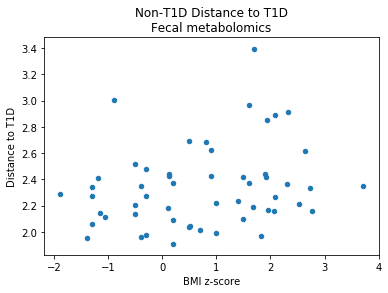

In [148]:
stool_dat = pd.DataFrame.from_dict(out_d["stool"]).merge(md.loc[:,['host_body_mass_index_z_score']], left_on = "names",right_index=True)
stool_dat["bmi_z"] = [float(x) for x in stool_dat["host_body_mass_index_z_score"]]
stool_dat.plot(x="bmi_z", y="data", kind="scatter", title="Non-T1D Distance to T1D\nFecal metabolomics").set(xlabel='BMI z-score',ylabel='Distance to T1D')

[Text(0, 0.5, 'Distance to T1D'), Text(0.5, 0, 'BMI z-score')]

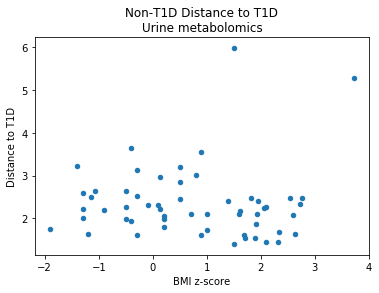

In [149]:
urine_dat = pd.DataFrame.from_dict(out_d["urine"]).merge(md.loc[:,['host_body_mass_index_z_score']], left_on = "names",right_index=True)
urine_dat["bmi_z"] = [float(x) for x in urine_dat["host_body_mass_index_z_score"]]
urine_dat.plot(x="bmi_z", y="data", kind="scatter", title="Non-T1D Distance to T1D\nUrine metabolomics").set(xlabel='BMI z-score',ylabel='Distance to T1D')

## weight over distance to T1D boxplots

In [150]:
urine_dat = pd.DataFrame.from_dict(out_d["urine"]).merge(md.loc[:,['host_body_mass_index_z_score',"analysis_weight_group"]], left_on = "names",right_index=True)
urine_dat["sample_type"] = "urine"
stool_dat = pd.DataFrame.from_dict(out_d["stool"]).merge(md.loc[:,['host_body_mass_index_z_score',"analysis_weight_group"]], left_on = "names",right_index=True)
stool_dat["sample_type"] = "fecal"

merged_dat = pd.concat([urine_dat, stool_dat])

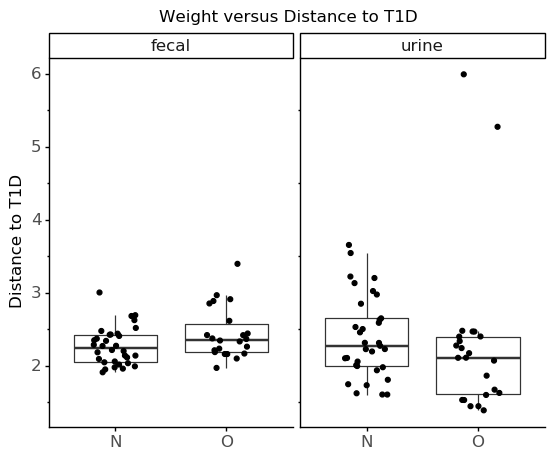

<ggplot: (-9223363268821619950)>

In [151]:
p = (pn.ggplot(data=merged_dat) +
    pn.geom_boxplot( mapping = pn.aes( x= "analysis_weight_group", y="data"), outlier_alpha=0) +
     pn.geom_jitter( mapping = pn.aes( x= "analysis_weight_group", y="data"), width=.2) +
     pn.labs(x="", y="Distance to T1D", title="Weight versus Distance to T1D") +
     pn.facet_grid('.~sample_type') +
     pn.theme_classic() +
     pn.theme(text = pn.element_text(size=12))
    )
p

In [7]:
urine_md.query('index=="172"')

,Adduct,CAS_Number,Charge,Compound_Name,Compound_Source,Data_Collector,ExactMass,FileScanUniqueID,INCHI,INCHI_AUX,...,SharedPeaks,Smiles,SpecCharge,SpecMZ,SpectrumFile,SpectrumID,TIC_Query,UpdateWorkflowName,tags,internalFilename
172,M+H,104-98-3,0,UROCANATE,Commercial standard,Prasad,138.043,spectra/specs_ms.mgf172,NaN,NaN,...,6,C1=C(NC=N1)C=CC(=O)O,1,139.05,specs_ms.mgf,CCMSLIB00000577945,15730000.0,UPDATE-SINGLE-ANNOTATED-GOLD,,specs_ms.mgf


# Randomforest

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [45]:
def rf_tuning(featrues, labels, max_estimators=175):
    # Author: Kian Ho <hui.kian.ho@gmail.com>
    #         Gilles Louppe <g.louppe@gmail.com>
    #         Andreas Mueller <amueller@ais.uni-bonn.de>
    #
    # License: BSD 3 Clause

    RANDOM_STATE = 123

    # Generate a binary classification dataset.
    X, y = featrues, labels

    # NOTE: Setting the `warm_start` construction parameter to `True` disables
    # support for parallelized ensembles but is necessary for tracking the OOB
    # error trajectory during training.
    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=RANDOM_STATE)),
        ("RandomForestClassifier, max_features=None",
            RandomForestClassifier(warm_start=True, max_features=None,
                                   oob_score=True,
                                   random_state=RANDOM_STATE))
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 15
    max_estimators = max_estimators

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(X, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()
    
def get_importances(feature_list, rf):
    importances = list(rf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    return([('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances])

def make_boxplot(df, var_col, value_col, axis_label, title=''):
    grps = set(df[var_col])
    anova_values = [list(df.loc[df[var_col] == x][value_col]) for x in grps]
    print(f_oneway(*anova_values))
    #PLOT
    plot_dat = df.copy()

    plot_dat["x_axis"] = pd.Categorical(df[var_col],
                                        categories=["NH",
                                                    "OH",
                                                    "NT1D",
                                                    "OT1D"])
    p = (pn.ggplot(data = plot_dat) +
    pn.geom_boxplot( pn.aes( x="x_axis", y=value_col), outlier_alpha=0) +
     pn.geom_jitter( pn.aes(x="x_axis", y=value_col), size=1, width=.1) +
     pn.labs( x="", y=axis_label, title=title) +
     pn.theme_classic(base_size=14) +
     pn.theme(
     axis_text = pn.element_text(color="black"),
     plot_title = pn.element_text(size=12))
     
    )
    return(p)



/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


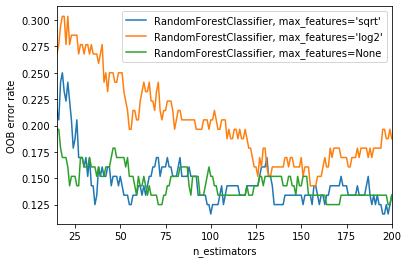

In [19]:
urine_df = urine_bt.to_dataframe().transpose().sort_index()
urine_samples = set(urine_df.index)
urine_sample_md = md.query('index in @urine_samples')
urine_sample_md = urine_sample_md.sort_index()

assert(all(urine_df.index==urine_sample_md.index))

urine_labels = np.array([1 if x=="T1D" else 0 for x in urine_sample_md.analysis_t1d])
# Saving feature names for later use
urine_feature_list = list(urine_df.columns)
# Convert to numpy array
urine_features = np.array(urine_df)


rf_tuning(urine_features, urine_labels, 200)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(urine_features, urine_labels, test_size=0.33, random_state=66)

urine_rf = RandomForestClassifier(n_estimators = 100, random_state = 42,warm_start=True, max_features=None,
                               oob_score=True)
# Train the model on training data
urine_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=True)

In [52]:
urine_predictions = urine_rf.predict(X_test)

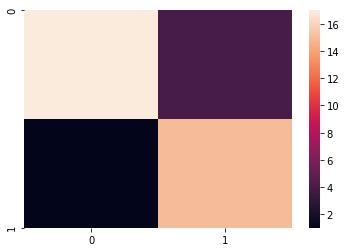

In [54]:
CM = confusion_matrix(y_test, urine_predictions)
import seaborn
seaborn.heatmap(CM)
plt.show()

In [57]:


urine_rf = RandomForestClassifier(n_estimators = 100, random_state = 42,warm_start=True, max_features=None,
                               oob_score=True)
# Train the model on training data
urine_rf.fit(urine_features, urine_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=True)

In [42]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

In [ ]:
CM = confusion_matrix(urine_labels, predictions)
print(conf_mat)

# Visualize it as a heatmap


In [58]:
urine_rf.oob_score_

0.8482142857142857

In [55]:
get_importances(urine_feature_list, urine_rf)

['Variable: 5753                 Importance: 0.12',
 'Variable: 252                  Importance: 0.1',
 'Variable: 2120                 Importance: 0.06',
 'Variable: 1248                 Importance: 0.04',
 'Variable: 1707                 Importance: 0.04',
 'Variable: 2768                 Importance: 0.04',
 'Variable: 3775                 Importance: 0.03',
 'Variable: 7784                 Importance: 0.03',
 'Variable: 2462                 Importance: 0.02',
 'Variable: 5231                 Importance: 0.02',
 'Variable: 6723                 Importance: 0.02',
 'Variable: 16                   Importance: 0.01',
 'Variable: 83                   Importance: 0.01',
 'Variable: 171                  Importance: 0.01',
 'Variable: 230                  Importance: 0.01',
 'Variable: 359                  Importance: 0.01',
 'Variable: 748                  Importance: 0.01',
 'Variable: 754                  Importance: 0.01',
 'Variable: 770                  Importance: 0.01',
 'Variable: 8

In [60]:
importances = list(urine_rf.feature_importances_)
pd.DataFrame({"feature":urine_feature_list,"var_imp":importances})\
    .sort_values("var_imp", ascending=False)\
    .head(10)\
    .style.bar("var_imp")

,feature,var_imp
5421,5753,0.220939
863,951,0.0798798
2233,2462,0.0728422
3490,3775,0.0692515
1523,1707,0.0327514
2515,2768,0.0247768
917,1017,0.0141283
1118,1248,0.0116777
4909,5231,0.0113139
5754,6096,0.0107685


In [75]:
urine_df = urine_bt.to_dataframe().transpose().sort_index()
urine_samples = set(urine_df.index)
urine_sample_md = md.query('index in @urine_samples')
urine_sample_md = urine_sample_md.sort_index()

assert(all(urine_df.index==urine_sample_md.index))

urine_labels = np.array(urine_sample_md.analysis_disease_stage_group)
# Saving feature names for later use
urine_feature_list = list(urine_df.columns)
# Convert to numpy array
urine_features = np.array(urine_df)

In [37]:
urine_rf = RandomForestClassifier(n_estimators = 100, random_state = 42,warm_start=True, max_features=None,
                               oob_score=True)
# Train the model on training data
urine_rf.fit(urine_features, urine_labels)

NameError: name 'RandomForestClassifier' is not defined

In [77]:
urine_rf.oob_score_

0.7946428571428571

In [78]:
get_importances(urine_feature_list, urine_rf)

['Variable: 4598                 Importance: 0.07',
 'Variable: 188                  Importance: 0.05',
 'Variable: 430                  Importance: 0.04',
 'Variable: 2462                 Importance: 0.04',
 'Variable: 172                  Importance: 0.03',
 'Variable: 5753                 Importance: 0.02',
 'Variable: 7784                 Importance: 0.02',
 'Variable: 3                    Importance: 0.01',
 'Variable: 185                  Importance: 0.01',
 'Variable: 216                  Importance: 0.01',
 'Variable: 260                  Importance: 0.01',
 'Variable: 303                  Importance: 0.01',
 'Variable: 440                  Importance: 0.01',
 'Variable: 465                  Importance: 0.01',
 'Variable: 623                  Importance: 0.01',
 'Variable: 827                  Importance: 0.01',
 'Variable: 951                  Importance: 0.01',
 'Variable: 1114                 Importance: 0.01',
 'Variable: 1201                 Importance: 0.01',
 'Variable: 

F_onewayResult(statistic=28.474384566364744, pvalue=1.2092555552718137e-13)


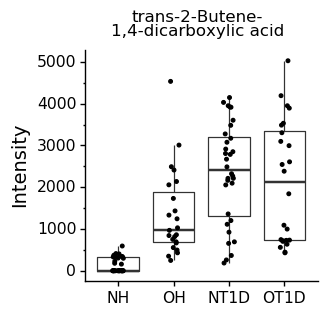

<ggplot: (8771888978952)>

In [48]:
butene_mets = [i for i,x in md_dict["urine"].items() if "trans-2-Butene-1,4-dicarboxylic acid" in x]
#gene_name = md_dict["urine"][gene]
urine_df = pd.DataFrame(urine_bt.to_dataframe().transpose().loc[:,butene_mets].sum(axis=1))
urine_df.columns=["value"]
urine_df = urine_df.join(md)
urine_df["value"] = [int(x) for x in urine_df["value"]]

pn.options.figure_size = (3,3)

make_boxplot(urine_df, "analysis_disease_stage_group", "value", "Intensity", "trans-2-Butene-\n1,4-dicarboxylic acid")




F_onewayResult(statistic=2.1566736197994176, pvalue=0.0973591651410048)


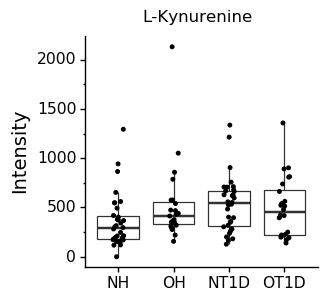

<ggplot: (-9223363264964911651)>

In [47]:
kynurenine_mets = [i for i,x in md_dict["urine"].items() if "Kynurenine" in x]
#gene_name = md_dict["urine"][gene]
urine_df = pd.DataFrame(urine_bt.to_dataframe().transpose().loc[:,kynurenine_mets].sum(axis=1))
urine_df.columns=["value"]
urine_df = urine_df.join(md)
urine_df["value"] = [int(x) for x in urine_df["value"]]

pn.options.figure_size = (3,3)

make_boxplot(urine_df, "analysis_disease_stage_group", "value", "Intensity","L-Kynurenine")



F_onewayResult(statistic=9.152914649946121, pvalue=1.8930682831536736e-05)


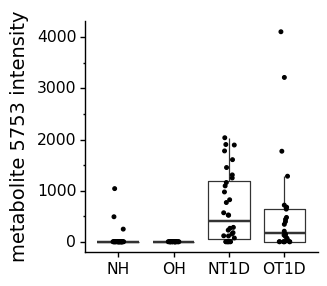

<ggplot: (-9223363294892179056)>

In [77]:
gene = "5753"
#gene_name = md_dict["urine"][gene]
urine_df = pd.DataFrame(urine_bt.to_dataframe().transpose())
urine_df = urine_df.loc[:,[gene]].join(md)
urine_df[gene] = [int(x) for x in urine_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(urine_df, "analysis_disease_stage_group", gene, "metabolite 5753 intensity")

F_onewayResult(statistic=9.236060502313297, pvalue=1.719722170929695e-05)


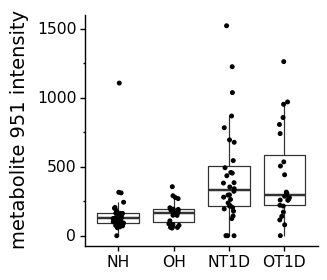

<ggplot: (-9223363294889562094)>

In [78]:
gene = "951"
#gene_name = md_dict["urine"][gene]
urine_df = pd.DataFrame(urine_bt.to_dataframe().transpose())
urine_df = urine_df.loc[:,[gene]].join(md)
urine_df[gene] = [int(x) for x in urine_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(urine_df, "analysis_disease_stage_group", gene, "metabolite 951 intensity")

F_onewayResult(statistic=19.818073332470817, pvalue=2.6199330714709284e-10)


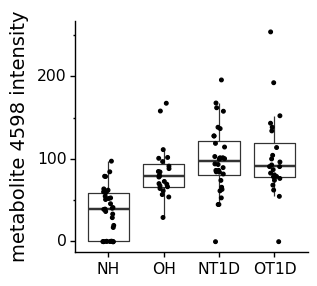

<ggplot: (-9223363265692600316)>

In [88]:
gene = "4598"
#gene_name = md_dict["urine"][gene]
urine_df = pd.DataFrame(urine_bt.to_dataframe().transpose())
urine_df = urine_df.loc[:,[gene]].join(md)
urine_df[gene] = [int(x) for x in urine_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(urine_df, "analysis_disease_stage_group", gene, "metabolite 4598 intensity")

F_onewayResult(statistic=23.57405058674058, pvalue=8.194032135566622e-12)


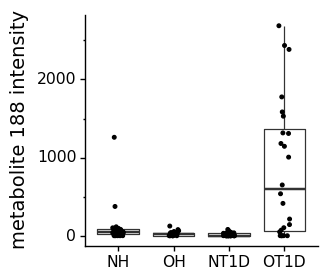

<ggplot: (8780033495679)>

In [22]:
gene = "188"
#gene_name = md_dict["urine"][gene]
urine_df = pd.DataFrame(urine_bt.to_dataframe().transpose())
urine_df = urine_df.loc[:,[gene]].join(md)
urine_df[gene] = [int(x) for x in urine_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(urine_df, "analysis_disease_stage_group", gene, "metabolite 188 intensity")

F_onewayResult(statistic=26.028117038389958, pvalue=9.527733649121787e-13)


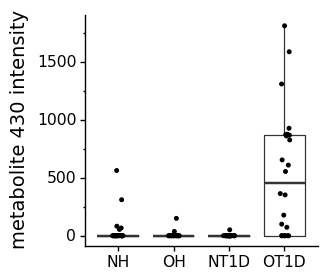

<ggplot: (-9223363256822261318)>

In [26]:
gene = "430"
#gene_name = md_dict["urine"][gene]
urine_df = pd.DataFrame(urine_bt.to_dataframe().transpose())
urine_df = urine_df.loc[:,[gene]].join(md)
urine_df[gene] = [int(x) for x in urine_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(urine_df, "analysis_disease_stage_group", gene, "metabolite 430 intensity")

F_onewayResult(statistic=17.2588962181406, pvalue=3.163249234694174e-09)


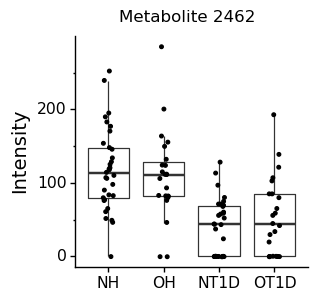

<ggplot: (8771892003062)>

In [49]:
gene = "2462"
#gene_name = md_dict["urine"][gene]
urine_df = pd.DataFrame(urine_bt.to_dataframe().transpose())
urine_df = urine_df.loc[:,[gene]].join(md)
urine_df[gene] = [int(x) for x in urine_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(urine_df, "analysis_disease_stage_group", gene, "Intensity", "Metabolite 2462")



F_onewayResult(statistic=19.148415917098234, pvalue=4.974427620213058e-10)


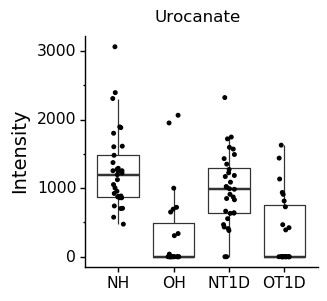

<ggplot: (-9223363264962514786)>

In [50]:
gene = "172"
#gene_name = md_dict["urine"][gene]
urine_df = pd.DataFrame(urine_bt.to_dataframe().transpose())
urine_df = urine_df.loc[:,[gene]].join(md)
urine_df[gene] = [int(x) for x in urine_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(urine_df, "analysis_disease_stage_group", gene, "Intensity", "Urocanate")



In [ ]:
 'Variable: 430                  Importance: 0.04',
 'Variable: 2462                 Importance: 0.04',
 'Variable: 172                  Importance: 0.03',

In [ ]:
1+1


/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/home/swandro/miniconda3/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


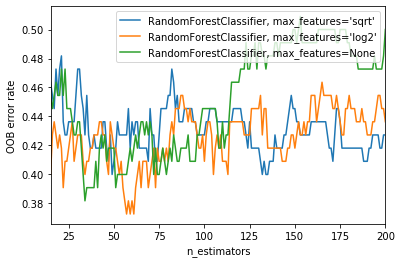

In [20]:
fecal_df = fecal_bt.to_dataframe().transpose().sort_index()
fecal_samples = set(fecal_df.index)
fecal_md = md.query('index in @fecal_samples')
fecal_md = fecal_md.sort_index()

assert(all(fecal_df.index==fecal_md.index))

fecal_labels = np.array([1 if x=="T1D" else 0 for x in fecal_md.analysis_t1d])
# Saving feature names for later use
fecal_feature_list = list(fecal_df.columns)
# Convert to numpy array
fecal_features = np.array(fecal_df)


rf_tuning(fecal_features, fecal_labels, 200)


In [11]:
fecal_rf = RandomForestClassifier(n_estimators = 100, random_state = 42,warm_start=True, max_features=None,
                               oob_score=True)
# Train the model on training data
fecal_rf.fit(fecal_features, fecal_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=42, verbose=0,
                       warm_start=True)

In [12]:
fecal_rf.oob_score_

0.5909090909090909

In [ ]:
1+1

In [14]:
get_importances(fecal_feature_list, fecal_rf)

['Variable: 214                  Importance: 0.06',
 'Variable: 489                  Importance: 0.03',
 'Variable: 828                  Importance: 0.03',
 'Variable: 632                  Importance: 0.02',
 'Variable: 663                  Importance: 0.02',
 'Variable: 775                  Importance: 0.02',
 'Variable: 872                  Importance: 0.02',
 'Variable: 979                  Importance: 0.02',
 'Variable: 1050                 Importance: 0.02',
 'Variable: 12                   Importance: 0.01',
 'Variable: 17                   Importance: 0.01',
 'Variable: 30                   Importance: 0.01',
 'Variable: 72                   Importance: 0.01',
 'Variable: 126                  Importance: 0.01',
 'Variable: 158                  Importance: 0.01',
 'Variable: 201                  Importance: 0.01',
 'Variable: 204                  Importance: 0.01',
 'Variable: 247                  Importance: 0.01',
 'Variable: 328                  Importance: 0.01',
 'Variable: 

F_onewayResult(statistic=3.4995607229934427, pvalue=0.01808449623648992)


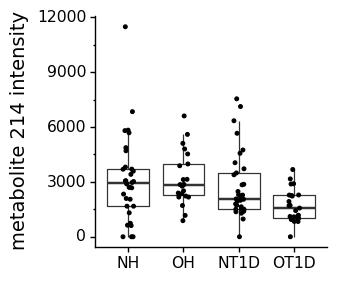

<ggplot: (8771892113444)>

In [15]:
gene = "214"
#gene_name = md_dict["fecal"][gene]
fecal_df = pd.DataFrame(fecal_bt.to_dataframe().transpose())
fecal_df = fecal_df.loc[:,[gene]].join(md)
fecal_df[gene] = [int(x) for x in fecal_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(fecal_df, "analysis_disease_stage_group", gene, "metabolite 214 intensity")

F_onewayResult(statistic=2.3504470648289764, pvalue=0.07654328215531385)


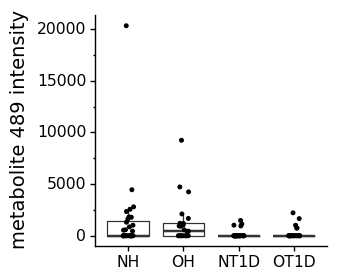

<ggplot: (8771892035420)>

In [16]:
gene = "489"
#gene_name = md_dict["fecal"][gene]
fecal_df = pd.DataFrame(fecal_bt.to_dataframe().transpose())
fecal_df = fecal_df.loc[:,[gene]].join(md)
fecal_df[gene] = [int(x) for x in fecal_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(fecal_df, "analysis_disease_stage_group", gene, "metabolite 489 intensity")

F_onewayResult(statistic=4.14816540231418, pvalue=0.008020912395593684)


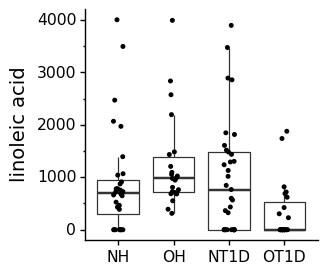

<ggplot: (8771892260956)>

In [18]:
gene = "828"
#gene_name = md_dict["fecal"][gene]
fecal_df = pd.DataFrame(fecal_bt.to_dataframe().transpose())
fecal_df = fecal_df.loc[:,[gene]].join(md)
fecal_df[gene] = [int(x) for x in fecal_df[gene]]

pn.options.figure_size = (3,3)

make_boxplot(fecal_df, "analysis_disease_stage_group", gene, "linoleic acid")

In [19]:
importances = list(fecal_rf.feature_importances_)
pd.DataFrame({"feature":fecal_feature_list,"var_imp":importances})\
    .sort_values("var_imp", ascending=False)\
    .head(10)\
    .style.bar("var_imp", vmax=.2)

,feature,var_imp
93,214,0.0564254
451,828,0.0343591
174,489,0.025507
574,979,0.0226071
611,1050,0.0204856
334,663,0.0187782
415,775,0.018715
306,632,0.0175973
486,872,0.0152002
124,348,0.0146595


In [20]:
list(md.columns)

['analysis_disease_stage',
 'analysis_disease_stage_group',
 'analysis_t1d',
 'analysis_weight_group',
 'anonymized_name',
 'autoimmune_disease_any',
 'bardet_biedl',
 'collection_timestamp',
 'congenital_hypothyroid',
 'description',
 'dna_extracted',
 'elevation',
 'empo_1',
 'empo_2',
 'empo_3',
 'env_biome',
 'env_feature',
 'env_material',
 'env_package',
 'ethnicity',
 'geo_loc_name',
 'hashimoto_no_med',
 'host_age',
 'host_age_units',
 'host_body_habitat',
 'host_body_mass_index',
 'host_body_mass_index_percentile',
 'host_body_mass_index_z_score',
 'host_body_product',
 'host_body_site',
 'host_height',
 'host_height_units',
 'host_life_stage',
 'host_scientific_name',
 'host_subject_id',
 'host_taxid',
 'host_weight',
 'host_weight_units',
 'lab_alt',
 'lab_alt_units',
 'lab_ast',
 'lab_ast_units',
 'lab_bun',
 'lab_bun_units',
 'lab_cholesterol',
 'lab_cholesterol_units',
 'lab_creatinine',
 'lab_creatinine_units',
 'lab_diastolic_bp',
 'lab_diastolic_bp_percentile',
 'lab_d

In [40]:
1+1

2

430
•	Pentaethylene glycol
•	Hexaethylene glycol
•	https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4235595/
•	https://journals.aace.com/doi/abs/10.4158/EP.4.5.272
172:Urocanate (identified)
	https://www.cell.com/cell/pdf/S0092-8674(18)31306-0.pdf


188: no network

951
•	D-glucosamine
•	http://www.center4research.org/glucosamine-supplements-good-joints-possibly-risky-diabetes/
5753
•	Hydroxycapric acid (long distance)
4598
•	Glutamine (long distance)
2462
•	N-ACETYL-D-TRYPTOPHAN
•	Tyrosine
•	N-Acetyl-O-methyltyrosine
•	https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4736430/
